In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
mnist = load_digits()

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

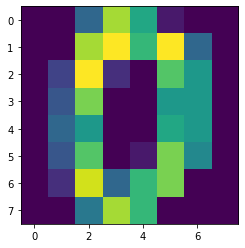

In [4]:
plt.imshow(mnist.images[0]);

In [5]:
from model.autoencoder import VAE

enc_dim = [28,24,16]
dec_dim = [16,24,28]
z_dim = 8
vae = VAE(enc_dim, dec_dim, z_dim)

/data/at3/scratch3/jharrison/miniconda3/envs/ML_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# return reconstruction error + KL divergence losses
import torch.nn.functional as F

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [7]:
#Train on GPU if possible 

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using available: {device}")
vae = vae.to(device)

Using available: cpu


In [8]:
#Set hyperparameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 15

In [9]:
import torch.optim as optim

optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [10]:
from torchvision import datasets, transforms

"""
Create dataloaders to feed data into the neural network
Default MNIST dataset is used and standard train/test split is performed
"""
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1)


In [11]:
x = next(iter(train_loader))

In [12]:
x[0].shape

torch.Size([128, 1, 28, 28])

In [13]:
for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader, 0):
        imgs, _ = data
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = vae(imgs)
        loss = loss_function(out, imgs, mu, logVar)

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {}: Loss {}'.format(epoch, loss))

Epoch 0: Loss 19340.0859375
Epoch 1: Loss 19749.20703125
Epoch 2: Loss 18751.2890625
Epoch 3: Loss 17923.283203125
Epoch 4: Loss 17592.177734375
Epoch 5: Loss 18558.6015625
Epoch 6: Loss 17459.544921875
Epoch 7: Loss 18027.38671875
Epoch 8: Loss 17808.79296875
Epoch 9: Loss 17601.849609375
Epoch 10: Loss 17262.361328125
Epoch 11: Loss 17806.609375
Epoch 12: Loss 17262.375
Epoch 13: Loss 16957.4140625
Epoch 14: Loss 17378.52734375


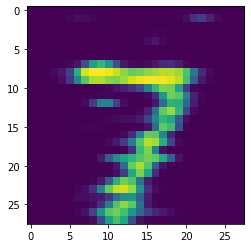

Truth label: tensor([7])


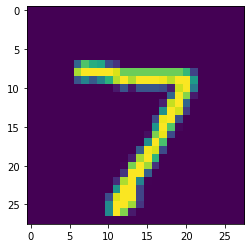

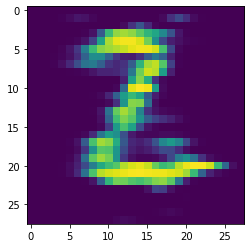

Truth label: tensor([2])


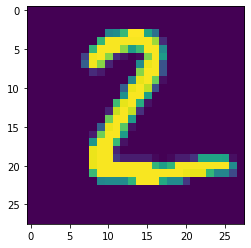

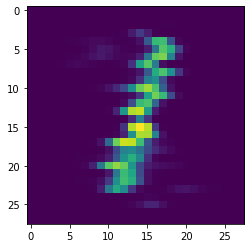

Truth label: tensor([1])


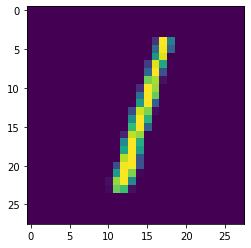

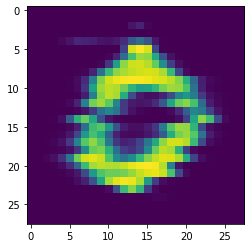

Truth label: tensor([0])


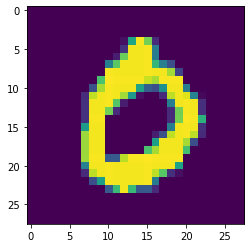

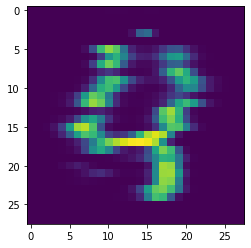

Truth label: tensor([4])


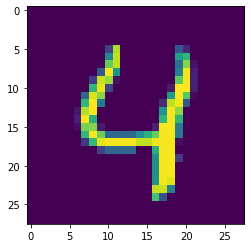

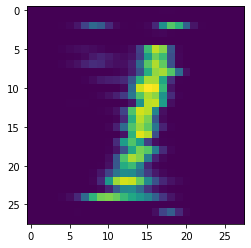

Truth label: tensor([1])


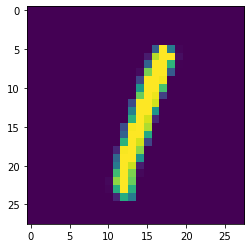

In [14]:
num_to_show = 5
with torch.no_grad():
    for i, test_example in enumerate(test_loader):
        if i > num_to_show:
            break
        y, mu, logVar = vae(test_example[0])
        plt.imshow(y.reshape(-1,28))
        plt.show()
        print(f"Truth label: {test_example[1]}")
        plt.imshow(test_example[0].reshape(-1,28))
        plt.show()
        

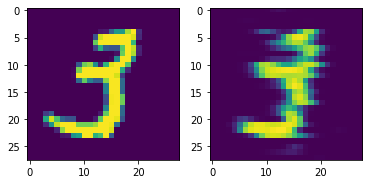

In [15]:
import random
import numpy as np
num_to_save = 0
with torch.no_grad():
    for i, data in enumerate(random.sample(list(test_loader), 1)):
        if i > num_to_save:
            break
        imgs, label = data
        label = int(label)
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = vae(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        plt.savefig(f'data/example_trained_output_class{label}.png')
        

In [21]:
example = vae.sample()

In [22]:
example.shape

torch.Size([1, 28])

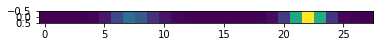

In [20]:
with torch.no_grad():
    plt.imshow(example)

In [23]:
import umap

In [28]:
num_examples = 100
mus = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        if i > num_examples:
            break
        imgs, label = data
        imgs = imgs.to(device)
        out, mu, logVAR = vae(imgs)
        mus.append(mu)

In [31]:
mus[0].shape

torch.Size([1, 1, 28, 8])